In [1]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb, rgb2gray

In [2]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified, cmap=plt.cm.gray)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

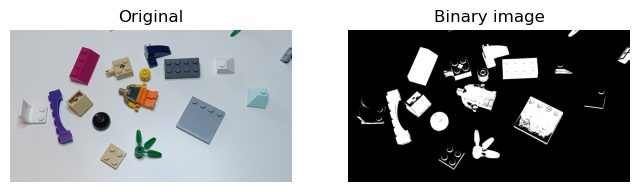

In [3]:
# exercise 1: show binary image
img_dir = "data/"
img_name = "lego_4_small.png"
input_img = io.imread(img_dir + img_name)
gray_img = rgb2gray(input_img)
otsu_thres = threshold_otsu(gray_img)
bin_img = gray_img < otsu_thres
show_comparison(input_img, bin_img, 'Binary image')

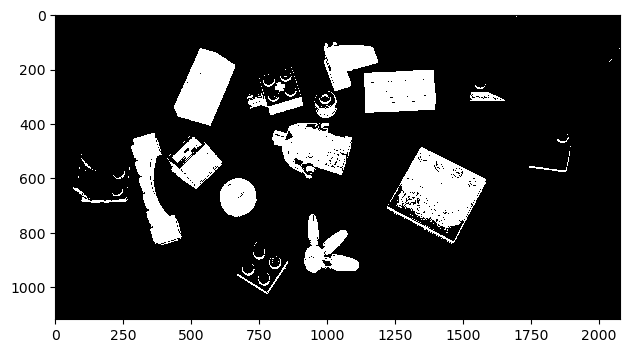

In [4]:
# exercise 2: remove border blobs
bin_img = segmentation.clear_border(bin_img)
io.imshow(bin_img)
io.show()

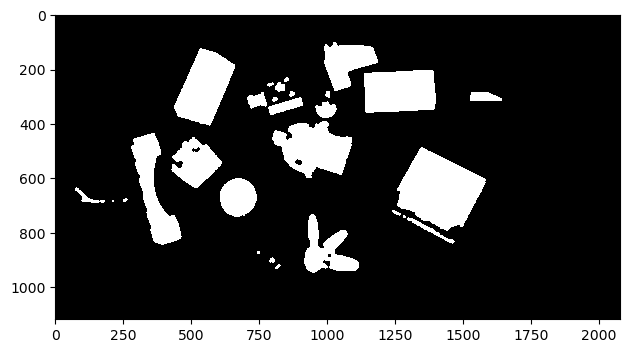

In [5]:
# exercise 3: cleaning use morphological operations
close_img = morphology.closing(bin_img, morphology.disk(5))
open_img = morphology.opening(close_img, morphology.disk(5))
io.imshow(open_img)
io.show()

In [6]:
# exercise 4: find labels

label_img = measure.label(open_img)
# labeled array, where all connected regions are assigned the same int value

n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 29


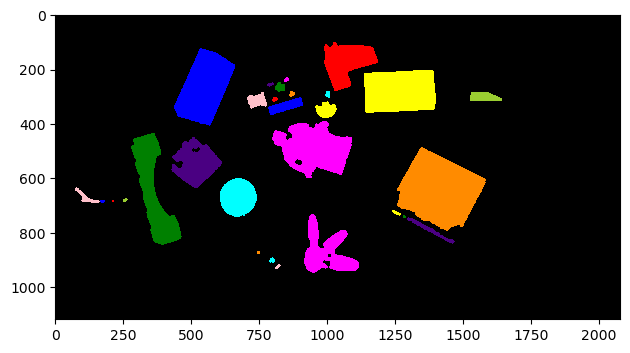

In [7]:
# exercise 5: visualise found labels

rgblabel_img = label2rgb(label_img)
# The result of blending a cycling colormap
# for each distinct value in label with the image

io.imshow(rgblabel_img)
io.show()

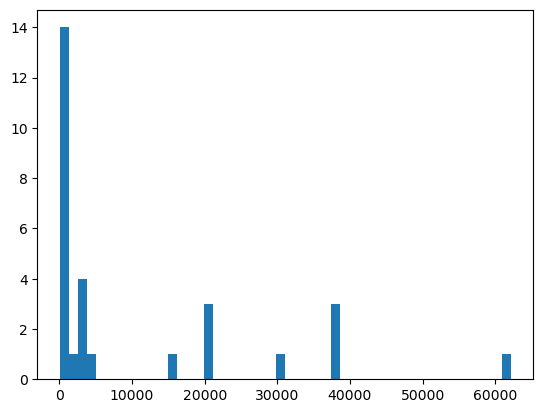

In [8]:
# exercise 6: compute blob features
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

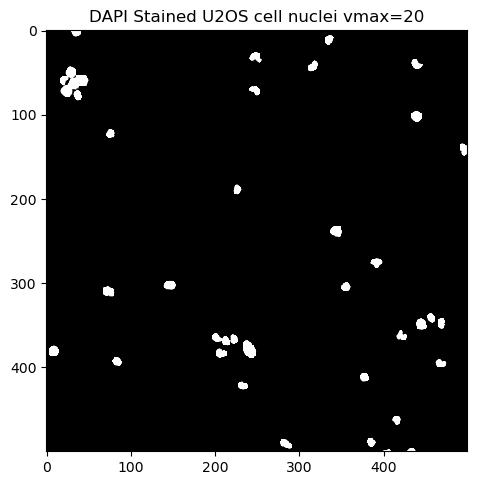

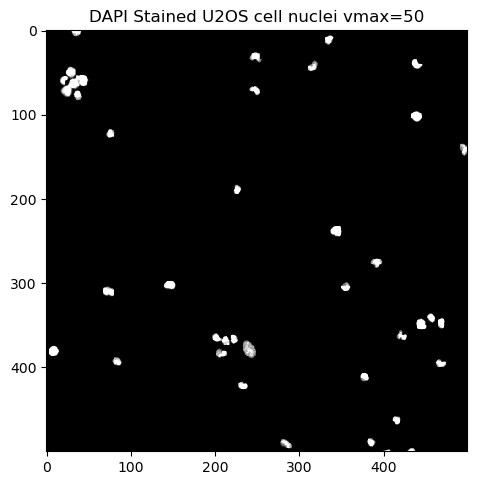

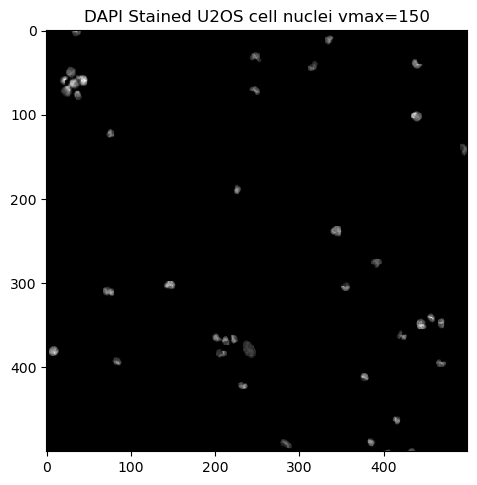

In [9]:
# exercise 7: cell counting
img_org = io.imread(img_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small)

# adjust vmin vmax to make cell nuclei most visible
for vmax in [20,50,150]:
    io.imshow(img_gray, vmin=10, vmax=vmax)
    plt.title(f'DAPI Stained U2OS cell nuclei vmax={vmax}')
    io.show()

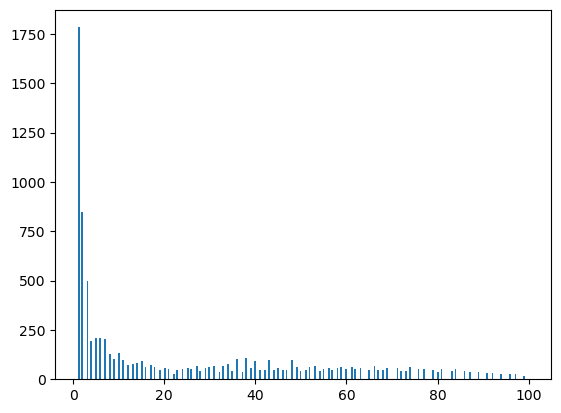

In [10]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

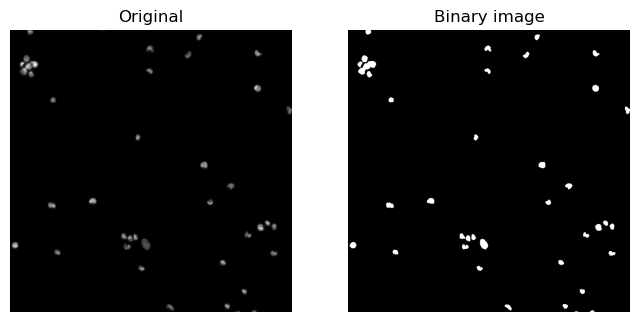

In [11]:
# exercies 8: threshold selection
otsu_thres = threshold_otsu(img_gray)
bin_img = img_gray > otsu_thres
show_comparison(img_gray, bin_img, 'Binary image')

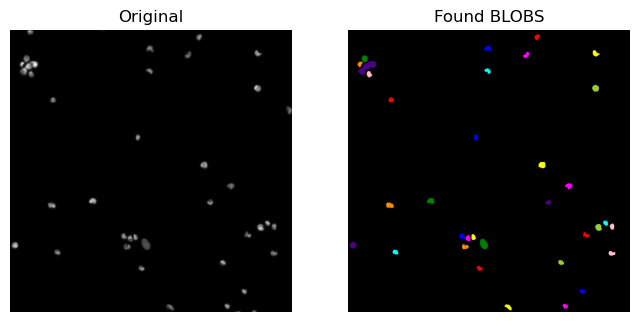

In [12]:
# exercise 9: remove border blobs, label2rgb
img_c_b = segmentation.clear_border(bin_img)
label_img = measure.label(img_c_b)
image_label_overlay = label2rgb(label_img)
show_comparison(img_small, image_label_overlay, 'Found BLOBS')

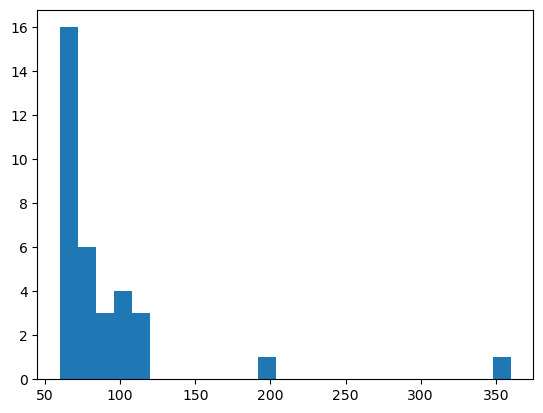

In [13]:
# exercise 10: blob features
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

plt.hist(areas, bins=25)
plt.show()

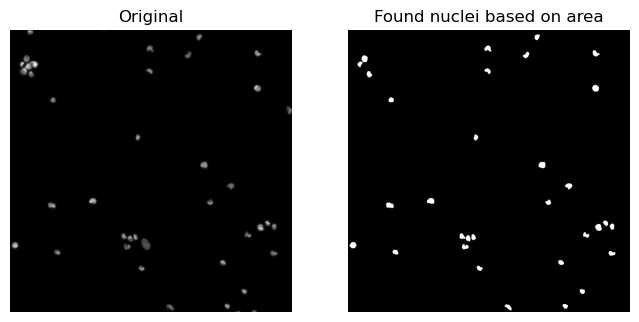

In [14]:
# exercise 11: blob classification by area
min_area = min(areas)
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
            
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

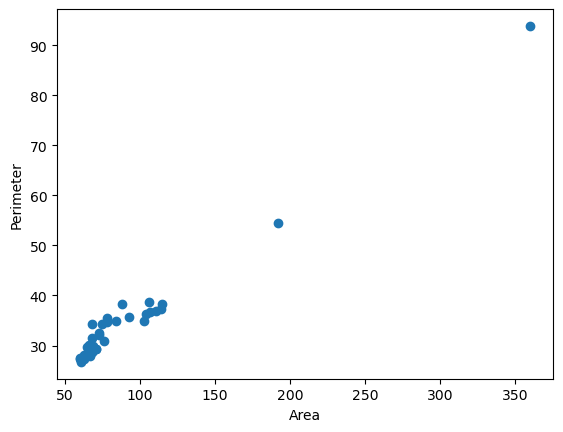

In [18]:
# exercise 12: feature space
perimeters = np.array([prop.perimeter for prop in region_props])

plt.scatter(areas, perimeters)
plt.xlabel("Area")
plt.ylabel('Perimeter')
plt.show()

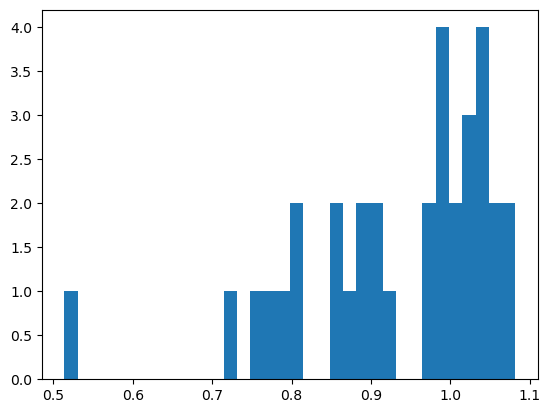

In [31]:
# exercise 13: BLOB circularity

def circularity(area, perimeter):
    f_circ = 4*math.pi*area/(perimeter**2)
    return f_circ
    
circ = [circularity(areas[i], perimeters[i]) for i in range(len(areas))]
plt.hist(circ, bins=len(circ))
plt.show()

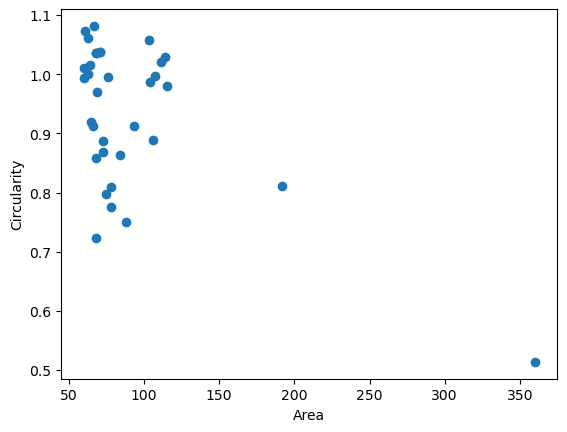

In [24]:
# Exercise 14 
plt.scatter(areas, circ)
plt.xlabel("Area")
plt.ylabel("Circularity")
plt.show()

Objects:  28


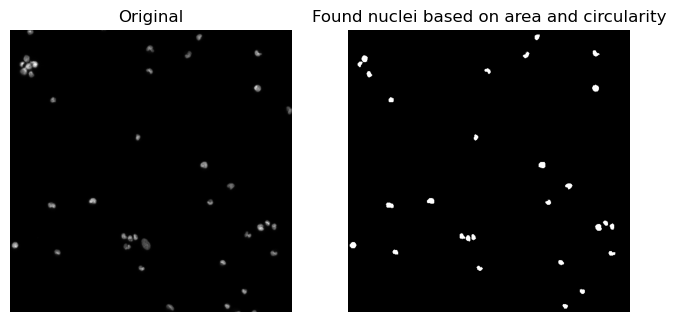

In [33]:
# Select cells with an appropriate range of accepted circularity and area
# Show them in an image.
min_area = 10
max_area = 150
label_img_filter = label_img
num_objects = 0
for region in region_props:
    p = region.perimeter
    a = region.area
    circ = circularity(a, p)
    if circ < 0.8 or a < min_area or a > max_area:
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
    else:
        num_objects += 1

print("Objects: ", num_objects)
i_circ = label_img_filter > 0
show_comparison(img_small, i_circ, 'Found nuclei based on area and circularity')